In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import holidays
import matplotlib.pyplot as plt
import math

In [10]:
# raw data
fact_order = pd.read_pickle('data/fact_order.pkl')
dim_store = pd.read_pickle('data/dim_store.pkl')
df = fact_order.join(dim_store.set_index('store_id'), on='store_id').drop('store_id', axis=1).reset_index()

In [11]:
# investigate the data
for i in dim_store.columns:
    if i in ["store_group","store_format","store_level","store_segment"]:
        print(f"---{i}:\n{dim_store[i].value_counts()} ")

---store_group:
Trực thuộc      43
Nhượng quyền    19
Name: store_group, dtype: int64 
---store_format:
Phố     42
Mall    20
Name: store_format, dtype: int64 
---store_level:
C      22
A      12
B      12
A+      1
A++     1
Name: store_level, dtype: int64 
---store_segment:
Mass          30
Mainstream    15
Flagship       3
Name: store_segment, dtype: int64 


In [12]:
dim_store[dim_store['store_level']=="C"].head()

,store_id,store_name,store_group,store_format,store_level,store_segment,store_area,number_of_staff,province
33,349962,VINCOM Q9,Trực thuộc,Mall,C,Mass,90.00,4.0,Hồ Chí Minh
36,349978,XÔ VIẾT NGHỆ TĨNH,Trực thuộc,Phố,C,Mass,56.00,4.0,Hồ Chí Minh
45,350028,CẦN THƠ,Nhượng quyền,Phố,C,Mass,52.00,3.0,Cần Thơ
47,350046,LÊ DUẨN ĐÀ NẴNG,Trực thuộc,Mall,C,Mass,55.12,5.0,Đà Nẵng
49,350056,RẠCH GIÁ,Trực thuộc,Phố,C,Mass,64.00,4.0,Kiên Giang


In [59]:
def preprocessing(df, store_name = 'AEON TÂN PHÚ', period = "Week"):
    if period == "Month":
        print("WIP")
    elif period == "Week":
        dataframe = df.copy()
        # rename columns
        dataframe.columns = ['date', 'sales', 'store', 'store_group', 'store_format', 'store_level', 'store_segment', 'store_area', 'number_of_staff', 'province']

        # set datetime index
        dataframe.date = pd.to_datetime(dataframe.date)
        dataframe.set_index('date', inplace=True)

        # remove wholesale orders (sales >20mil)
        dataframe = dataframe.loc[dataframe.sales < 20000000]

        # trim dates
        date_start = datetime.date(2018, 1, 1)
        # date_start = datetime.date(2017, 9, 1)
        date_end = datetime.date(2021, 3, 31)
        dataframe = dataframe.sort_index().loc[date_start:date_end+datetime.timedelta(days=1)]

        # keep only stores with data from date_start to date_end; remove the rest
        store_groups = dataframe.groupby('store')
        dataframe = store_groups.filter(lambda group: (group.index.min().date() == date_start) & (group.index.max().date() == date_end))
        #df.store.drop_duplicates()#.shape

        # missing values
        data = dataframe[['sales', 'store']].groupby('store').resample('D').sum()
        data.replace(0, np.nan, inplace=True)
        data.sort_values('sales')
        nan_idx = np.where(data.sales.isna())
        data.iloc[nan_idx]
        data = (data.groupby('store')).transform(lambda x : x.interpolate()).reset_index('store')
        data.iloc[nan_idx]

        # add holiday
        holiday = pd.DataFrame(holidays.Vietnam(years=[2018, 2019, 2020, 2021]).items()).rename({0:'date', 1:'holiday_neg'}, axis=1).set_index('date')
        holiday.index = pd.PeriodIndex(holiday.index, freq='D')
        # set to 1 if holiday affect sales negatively
        holiday.replace({'Vietnamese New Year.*': 1, 
                         '.*day of Tet Holiday': 1,
                         'International Labor Day': 1,
                         '\D': 0}, 
                        regex=True, inplace=True)

        data.index = data.index.to_period('D')
        data = pd.merge(data, holiday, how='left', left_index=True, right_index=True)

        # resample to weekly frequency
        data=data[data['store']==store_name]
        data = data[['sales','holiday_neg']].resample('W',kind='timestamp',label ='right').sum()
        return data
    else:
        print("Error, chosen period not available")   


In [62]:
final_df = preprocessing(df)

In [63]:
def plot_series(data,figsize=(12,6)):
    plt.figure(figsize=figsize)
    plt.title('Quantity Timeseries')
    plt.xticks(rotation=45)
    plt.plot(data) 

In [64]:
final_df

,sales,holiday_neg
date,,
2018-01-07,370883945.0,0.0
2018-01-14,358100007.0,0.0
2018-01-21,370572920.0,0.0
2018-01-28,387209980.0,0.0
2018-02-04,569364028.0,0.0
...,...,...
2021-03-07,193845880.0,0.0
2021-03-14,161916950.0,0.0
2021-03-21,157507090.0,0.0


In [124]:
final_df[final_df['holiday_neg']>0].index

DatetimeIndex(['2018-02-18', '2018-02-25', '2018-05-06', '2019-02-10',
               '2019-05-05', '2020-01-26', '2020-02-02', '2020-05-03',
               '2021-02-14', '2021-02-21'],
              dtype='datetime64[ns]', name='date', freq=None)

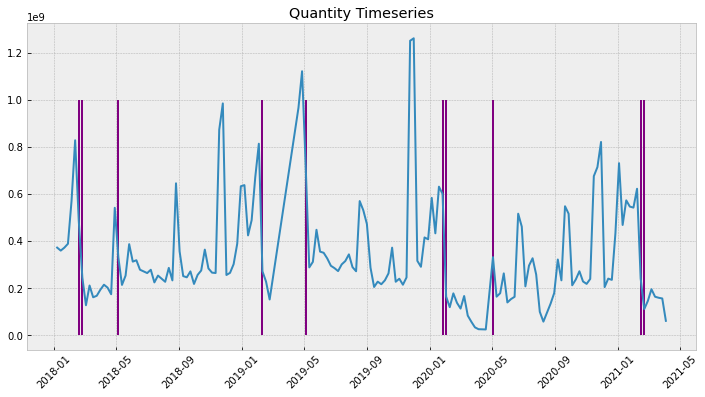

In [126]:
plot_series(final_df['sales'])
plt.vlines(x=final_df[final_df['holiday_neg']>0].index,ymin = 0, ymax = 10e8,colors = 'purple')

In [66]:
# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer,QuantileTransformer, OneHotEncoder
from sklearn.metrics import mean_squared_error
# Keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, GRU
from keras.models import Sequential
from keras.regularizers import l2
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#Visualization
import matplotlib.cm as cm
from sklearn import random_projection
# statmodel
from statsmodels.tsa.seasonal import seasonal_decompose
from chart_studio.plotly import plot_mpl
import datetime

import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('bmh')
import statsmodels.api as sm
import matplotlib

In [81]:
def getDateRangeFromWeek(x): 
    d = str(x['Year']) + "-W" + str(x['Week'])
    r = datetime.datetime.strptime(d + '-1', "%Y-W%W-%w")
    return r

def getDateRangeFromMonth(x): 
    if len(str(x['Month'])) ==1:
        m = "0" + str(x['Month'])
    else:   
        m = x['Month']
    d = str(x['Year']) + "-" +  m + "-" + "01"
    r = datetime.datetime.strptime(d, "%Y-%m-%d")
    return r

def preprocessing(dataframe,product_id, period = "Month"):
    if period == "Month":
        data = dataframe[dataframe['ProductName_ID'] == product_id]
        data = data.groupby(['Year','Month']).sum()['Quantity'].reset_index()
        data['Month'] =  data['Month'].astype('string').apply(lambda x: x if int(x) >=10 else "0"+x)
        data['TimeSeries'] = data[['Year','Month']].apply(getDateRangeFromMonth,axis  = 1)
        #drop non-relevant columns
        data.drop(['Year','Month'], axis=1, inplace=True)
        data.set_index('TimeSeries',inplace=True)
        data.sort_index(inplace=True)
        print("monthly timeseries generated")
        return data
    elif period == "Week":
        data = dataframe[dataframe['ProductName_ID'] == product_id]
        data = data.groupby(['Year','Week']).sum()['Quantity'].reset_index()      
        data['Week'] =  data['Week'].astype('string').apply(lambda x: x if int(x) >=10 else "0"+x)
        data = data[data['Week'] != "53"]
        data['TimeSeries'] = data[['Year','Week']].apply(getDateRangeFromWeek,axis  = 1)
        #drop non-relevant columns
        data.drop(['Year','Week'], axis=1, inplace=True)
        data.set_index('TimeSeries',inplace=True)
        data.dropna(inplace=True)
        data.sort_index(inplace=True)
        print("weekly timeseries generated")
        return data
    else:
        print("Error, chosen period not available")   

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))
# evaluate the RMSE for each forecast time step

def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = math.sqrt(mean_squared_error(actual,predicted))
        mape = mean_absolute_percentage_error(actual,predicted)
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAPE: %0.4f' % ((i+1), mape))

def plot_series(data,figsize=(12,6)):
    plt.figure(figsize=figsize)
    plt.title('Quantity Timeseries')
    plt.xticks(rotation=45)
    plt.plot(data)      

# plot the forecasts in the context of the original dataset
def plot_forecasts(series,train_df, val_df, forecasts, out):
    plt.figure(figsize=(12,6))
    # plot the entire dataset in blue
    plt.plot(data.loc[train_df.index], label = "Train")
    plt.plot(data.loc[val_df.index], label = "Validation")
    if out == 1:
        lines = pd.Series()
        for i in range(len(forecasts)):
            off_s = len(series) - len(val_df) + i - 1
            off_e = off_s + len(forecasts[i])
            xaxis = [x for x in range(off_s, off_e)]
            yaxis = forecasts[i]
            lines = lines.append(pd.Series(yaxis[0],index = xaxis))
        plt.plot(lines.index, lines.values, color='red')
    # show the plot
        plt.xticks(rotation = 90)
        left, right = plt.xlim()
        plt.xlim(left = (left+right)/2,right=right)
        plt.show()
        return lines
    # plot the forecasts in red
    else:
        for i in range(len(forecasts)):
            off_s = len(series) - len(val_df) + i - 1
            off_e = off_s + len(forecasts[i])
            xaxis = [x for x in range(off_s, off_e)]
            yaxis = forecasts[i]
            plt.plot(xaxis, yaxis, color='red')
        # show the plot
        plt.xticks(rotation = 90)
        left, right = plt.xlim()
        plt.xlim(left = (left+right)/2,right=right)
        plt.show()
def gridSearchARIMA(data, exog=None, seasonal = 12, searchRange = range(0,2)):
    p = q = searchRange
    d = range(0,2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal) for x in list(itertools.product(p, d, q))]
    print('Examples of parameter combinations for Seasonal ARIMA...')
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
    print('...')
    print('Running grid search...')
    arima_grid = {}
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=param,
                                                exog=exog,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                arima_grid[f'{param}x{param_seasonal}'] = results.aic
                #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    model = min(arima_grid, key=arima_grid.get)
    print("Model have lowest AIC score:", model)
    print("AIC score:", arima_grid[model])
    return arima_grid

def modelARIMAfit(data, exog=None, order = (1, 1, 1), seasonal_order= (0, 1, 1, 12)):
    mod = sm.tsa.statespace.SARIMAX(data,
                                order=order,
                                seasonal_order=seasonal_order,
                                exog=exog,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    #print(results.summary().tables[1])
    return results

def oneStepForecast(results, data,test_len = 0.8):
    test_start = data.iloc[int(len(data)*test_len)].name
    pred = results.get_prediction(start=test_start, dynamic=False)
    pred_ci = pred.conf_int()
    # plot
    ax = data.plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(12, 6))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Furniture Sales')
    plt.legend()
    plt.show()
    y_forecasted = pred.predicted_mean
    y_truth = data[test_start:]['sales'].values
    rmse = math.sqrt(((y_forecasted - y_truth) ** 2).mean())
    mape = mean_absolute_percentage_error(y_truth,y_forecasted)
    print('RMSE = {}'.format(round(rmse, 2)))
    print('MAPE = {}'.format(round(mape, 4)))
    return rmse, mape

def multiStepForecast(data, order, seasonal_order, test_len = 0.8, steps = 3):
    test_start = data.iloc[int(len(data)*test_len)].name
    test_stop = data.iloc[-steps].name
    oos_prediction = list()
    oos_actual = list()
    print(f"Calculating forecasts with {steps} steps ahead")
    for i,date in enumerate(data[test_start:test_stop].index):
        results = modelARIMAfit(data[:date][:-1], order = order, seasonal_order= seasonal_order)   
        pred_uc = results.get_forecast(steps=steps)
        oos_prediction.append(pred_uc.predicted_mean.values)
        oos_actual.append(data[date:][:steps]['sales'].values)
    return oos_prediction, oos_actual

def evaluateForecastARIMA(oos_prediction,oos_actual, steps):
    for i in range(steps):
        actual = [row[i] for row in oos_actual]
        predicted = [forecast[i] for forecast in oos_prediction]
        rmse = math.sqrt(mean_squared_error(actual,predicted))
        mape = mean_absolute_percentage_error(actual,predicted)
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAPE: %0.4f' % ((i+1), mape))

def multiStepForecast_future(results,steps):
    pred_uc = results.get_forecast(steps=steps)
    pred_ci = pred_uc.conf_int()
    ax = data.plot(label='observed', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Furniture Sales')
    plt.legend()
    plt.show()
    return pred_uc.predicted_mean

In [85]:
final_df['date']

340    2018-01-01/2018-01-07
341    2018-01-08/2018-01-14
342    2018-01-15/2018-01-21
343    2018-01-22/2018-01-28
344    2018-01-29/2018-02-04
               ...          
505    2021-03-01/2021-03-07
506    2021-03-08/2021-03-14
507    2021-03-15/2021-03-21
508    2021-03-22/2021-03-28
509    2021-03-29/2021-04-04
Name: date, Length: 170, dtype: period[W-SUN]

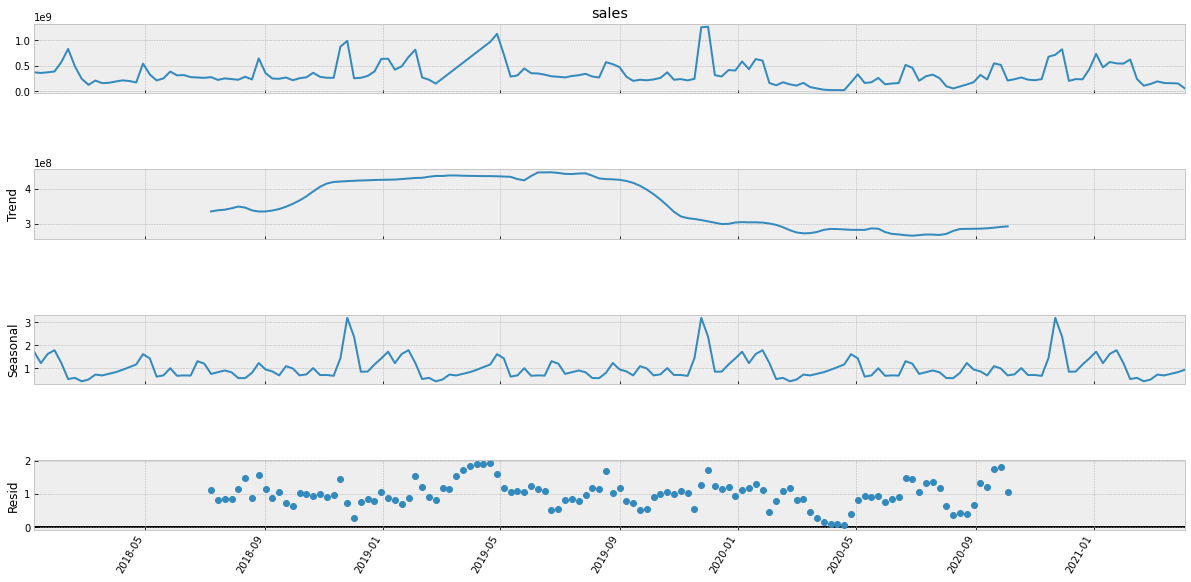

In [68]:
ts_data = final_df['sales']
result = seasonal_decompose(ts_data, model='multiplicative')
fig = result.plot()
fig.set_size_inches(18, 10)
fig.autofmt_xdate( bottom=0.2, rotation=60, ha='right', which='major')
#plot_mpl(fig)

In [94]:
arima_grid = gridSearchARIMA(final_df.iloc[:,0],exog=final_df.iloc[:,1:], seasonal =52, searchRange = range(0,3))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 0, 2, 52)
...
Running grid search...
Model have lowest AIC score: (2, 0, 1)x(2, 0, 1, 52)
AIC score: 16.0


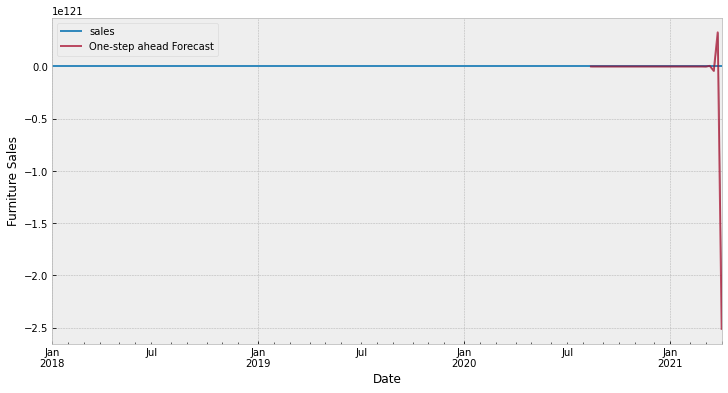

RMSE = 4.3429954098355363e+120
MAPE = 1.3153810340157184e+112


In [109]:
results = modelARIMAfit(final_df[['sales']], order = (2, 0, 1), seasonal_order= (2, 0, 1, 52))
rmse, mape = oneStepForecast(results,final_df[['sales']])

In [98]:
order = (2, 0, 1)
seasonal_order= (2, 0, 1, 52)

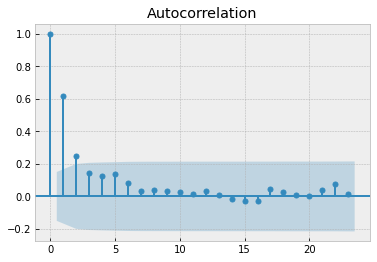

In [102]:
plot_acf(final_df[['sales']])
plt.show()

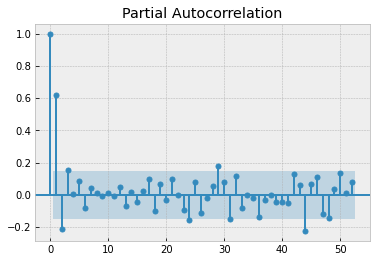

In [106]:
plot_pacf(final_df[['sales']], lags=52)
plt.show()

In [99]:
oos_prediction, oos_actual = multiStepForecast(final_df[['sales']], order = order, seasonal_order= seasonal_order, test_len = 0.9, steps = 6)
evaluateForecastARIMA(oos_prediction, oos_actual,steps = 6)

Calculating forecasts with 6 steps ahead
t+1 RMSE: 1067931287917214266442917849123160599538630285299328017125762802151520098938134214150943146593377023539141768499407532064768.000000
t+1 MAPE: 2953927910655593182788650535629193896184351433157713660943064177525708664872492207734966262215831722373804898385920.0000
t+2 RMSE: 9505489623257905930947649047773152153383331727682337067624799687449226369290399536462669004541845599390027692844665601523712.000000
t+2 MAPE: 21940260361988462562584862333171433187802816974612755892122484240958413097222536556743464887034869741533783614554112.0000
t+3 RMSE: 84606881800301722198484314343529061896501898334160862608963057573822312998134117005067978058122135722456879107991673214337024.000000
t+3 MAPE: 145603798216941336711353404474048392862461254781896583120614477222523160539246276713113099738853659652761504326877184.0000
t+4 RMSE: 753072697072687128813843344765491910920743454570385493578094560253620232922739867953153729501058749764762686571402487811538944

In [113]:
final_df[['sales']].reset_index().to_csv("ts_sales.csv")